# Gradient Approach

In [51]:
import os

from matplotlib import pyplot as plt
from utils.edge_extraction import *
import cv2
from utils.feature_extraction import *
from utils.image_conversion import *

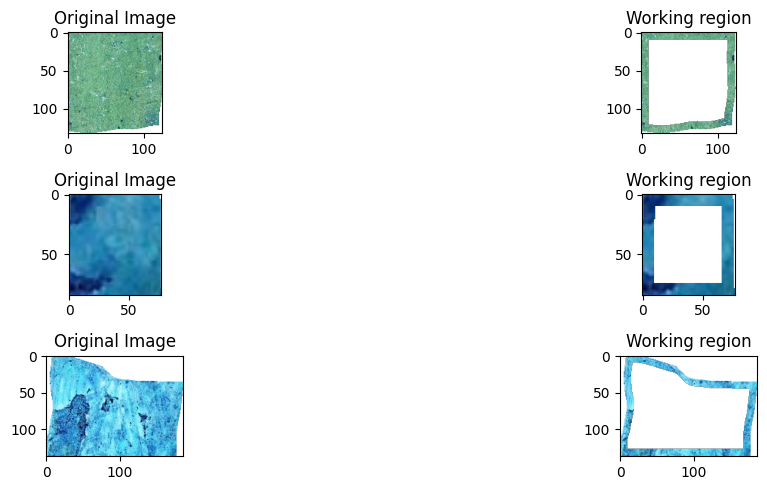

In [52]:
image_green1 = cv2.imread("data/5.34.1.png", cv2.IMREAD_UNCHANGED)
image_green2 = cv2.imread("data/5.38.15.png", cv2.IMREAD_UNCHANGED)
image_yellow = cv2.imread("data/5.34.34.png", cv2.IMREAD_UNCHANGED)

working_region_image_green1 = extract_working_region(image_green1, threshold=10)
working_region_image_green2 = extract_working_region(image_green2, threshold=10)
working_region_image_yellow = extract_working_region(image_yellow, threshold=10)

fig, axes = plt.subplots(3, 2, figsize=(15, 5))
images = [image_green1, working_region_image_green1, image_green2, working_region_image_green2, image_yellow, working_region_image_yellow]
titles = ["Original Image", "Working region"]

for i, ax_row in enumerate(axes):
    for j, ax in enumerate(ax_row):
        ax.imshow(images[i * 2 + j])
        ax.set_title(titles[j])

plt.tight_layout()
plt.show()

In [53]:
print(image_green1.shape)
print(image_green2.shape)
print(image_yellow.shape)

(132, 124, 4)
(84, 77, 4)
(137, 187, 4)


In [54]:
def get_only_valid_pixels(input_image: np.ndarray) -> np.ndarray:
    # Extract pixels with alpha channel value different from 0
    valid_pixels = input_image[input_image[:, :, 3] != 0]

    # Reshape to (num_pixels, 4)
    reshaped_image = valid_pixels.reshape((-1, 4))

    # Determine the dimensions of the reshaped image
    num_pixels = reshaped_image.shape[0]
    width = int(np.sqrt(num_pixels))
    height = (num_pixels + width - 1) // width

    # Pad the reshaped image to make it rectangular
    padded_image = np.zeros((height * width, 4), dtype=np.uint8)
    padded_image[:num_pixels, :] = reshaped_image

    # Reshape the padded image to the desired dimensions
    final_image = padded_image.reshape((height, width, 4))

    # Split channel
    b, g, r, a = cv2.split(final_image)
    rgb_image = cv2.merge((b, g, r))

    return rgb_image

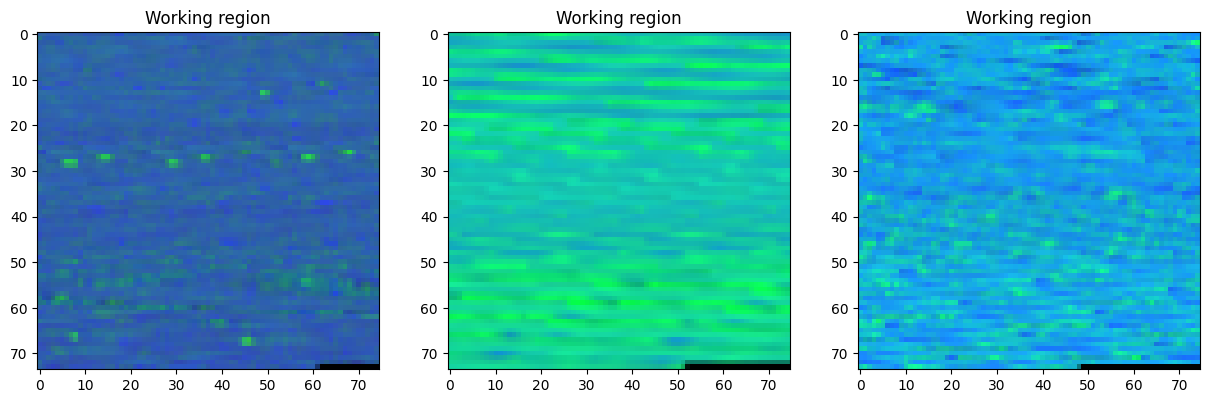

In [55]:
working_region_image_green1 = get_only_valid_pixels(working_region_image_green1)
working_region_image_green2 = get_only_valid_pixels(working_region_image_green2)
working_region_image_yellow = get_only_valid_pixels(working_region_image_yellow)

working_region_image_green1 = cv.cvtColor(working_region_image_green1, cv.COLOR_BGR2HSV)
working_region_image_green2 = cv.cvtColor(working_region_image_green2, cv.COLOR_BGR2HSV)
working_region_image_yellow = cv.cvtColor(working_region_image_yellow, cv.COLOR_BGR2HSV)

max_x = max(working_region_image_green1.shape[0], working_region_image_green2.shape[0], working_region_image_yellow.shape[0])
max_y = max(working_region_image_green1.shape[1], working_region_image_green2.shape[1], working_region_image_yellow.shape[1])

working_region_image_green1 = cv2.resize(working_region_image_green1, (max_x, max_y))
working_region_image_green2 = cv2.resize(working_region_image_green2, (max_x, max_y))
working_region_image_yellow = cv2.resize(working_region_image_yellow, (max_x, max_y))

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
images = [working_region_image_green1, working_region_image_green2,working_region_image_yellow]
titles = ["Working region"]

for i, ax in enumerate(axes):
    ax.imshow(images[i])
    ax.set_title(titles[0])

plt.show()

In [56]:
print(working_region_image_green1.shape)
print(working_region_image_green2.shape)
print(working_region_image_yellow.shape)

(74, 75, 3)
(74, 75, 3)
(74, 75, 3)


In [57]:
jacobian_yellow = compute_image_gradient(working_region_image_yellow[:,:,:3])
jacobian_yellow

array([[[[  23. ,   27. ,  -18. , ...,  -14. ,    0. ,  -26. ],
         [  10.5,    3. ,  -15.5, ...,  -28.5,  -51. ,  -68. ],
         [ -30. ,    3. ,  -15.5, ...,   -8.5,  -12.5,  -13. ],
         ...,
         [  -7.5,    1.5,   12.5, ...,   -2.5,    2.5,   -2.5],
         [ -31.5,  -42.5,  -22.5, ..., -125.5, -124. , -122. ],
         [ -44. ,  -84. ,  -54. , ..., -229. , -245. , -238. ]],

        [[  -1. ,   -1. ,   -2. , ...,   -1. ,    0. ,    0. ],
         [  -0.5,   -0.5,   -1.5, ...,    0.5,    0.5,   -1. ],
         [   0. ,    0. ,    0. , ...,    0.5,    1. ,    1. ],
         ...,
         [  -0.5,    0. ,   -0.5, ...,   -1. ,   -1.5,   -1.5],
         [  -2.5,   -2.5,   -1.5, ...,  -12. ,  -12. ,  -12. ],
         [  -3. ,   -4. ,   -3. , ...,  -23. ,  -22. ,  -22. ]],

        [[ -23. ,  -27. ,    8. , ...,   10. ,    3. ,   18. ],
         [ -10.5,   -4.5,    8.5, ...,   27. ,   53. ,   54. ],
         [  29. ,   -3. ,   14.5, ...,   -1. ,    6. ,   12.5],
        

In [58]:
jacobian_green = compute_image_gradient(working_region_image_green1[:,:,:3])
jacobian_green - jacobian_yellow

array([[[[ -49. ,  -23. ,   21. , ...,   19. ,   33. ,   93. ],
         [  -9.5,    1. ,    9.5, ...,   22.5,   59. ,  100.5],
         [  49.5,   -2.5,    5. , ...,    3. ,    4.5,   12. ],
         ...,
         [  -4.5,    1. ,  -19. , ...,   -9.5,  -15. ,  -10. ],
         [  24.5,   42. ,   36. , ...,   44. ,   37.5,   33.5],
         [  53. ,   75. ,   63. , ...,   70. ,   88. ,   94. ]],

        [[ -10. ,  -10. ,   -7. , ...,    9. ,   11. ,   10. ],
         [  -2. ,   -2.5,   -1. , ...,    3. ,    4.5,    5.5],
         [   3. ,    3.5,    2.5, ...,   -2.5,   -2.5,   -2.5],
         ...,
         [   0. ,   -0.5,    1. , ...,   -2. ,   -1.5,   -2. ],
         [   2.5,    2.5,    2. , ...,  -10. ,  -10. ,  -10.5],
         [   3. ,    5. ,    4. , ...,  -16. ,  -17. ,  -17. ]],

        [[  38. ,   21. ,  -12. , ...,  -10. ,  -21. ,  -68. ],
         [   7.5,   -0.5,   -7.5, ...,  -18. ,  -53.5,  -76. ],
         [ -39. ,    6. ,   -4.5, ...,    7. ,    1.5,  -10. ],
        

In [59]:
def create_dataset(img_dir = "./data"):
    
    working_regions = []
    for file in os.listdir(img_dir):    
        if os.path.splitext(file)[1] != ".png":
            continue
        
        image = cv.imread(os.path.join(img_dir, file), cv.IMREAD_UNCHANGED)
        working_region = extract_working_region(image, threshold=5)
        working_regions.append(filter_working_region(working_region))
        
    max_width = max(array.shape[1] for array in working_regions)
    max_height = max(array.shape[0] for array in working_regions)
   
    jacobians = []
    for working_region in working_regions:
        reshaped_working_region = cv.resize(working_region, (max_width, max_height))
        reshaped_working_region = cv.cvtColor(reshaped_working_region, cv.COLOR_BGR2HSV)
        jacobian = compute_image_gradient(reshaped_working_region)
        jacobians.append(jacobian)
    
    return np.array(jacobians)
        

In [60]:
%time X = create_dataset(img_dir = "./data")
X

CPU times: user 1.04 s, sys: 81.6 ms, total: 1.12 s
Wall time: 1.01 s


array([[[[[   6. ,    6. ,    6. , ...,    0. ,    1. ,    1. ],
          [  15. ,   15. ,   15. , ...,    0.5,    1.5,    2. ],
          [  24. ,   24. ,   24. , ...,    1. ,    2.5,    2.5],
          ...,
          [  -6.5,   -6. ,   -6. , ...,  -25. ,  -25.5,  -25.5],
          [  -4. ,   -4. ,   -3.5, ...,  -15.5,  -15.5,  -16. ],
          [  -1. ,   -2. ,   -1. , ...,   -6. ,   -6. ,   -6. ]],

         [[  15. ,   14. ,   13. , ...,    0. ,   -1. ,   -1. ],
          [ -65.5,  -66. ,  -66. , ...,    0. ,    0. ,   -0.5],
          [ -70.5,  -69.5,  -69.5, ...,    0.5,   -0.5,    1. ],
          ...,
          [   0. ,    3. ,    0. , ...,  -18. ,  -18. ,  -18. ],
          [   3. ,    0. ,    5. , ...,  -15. ,  -15. ,  -20. ],
          [   6. ,   -6. ,   10. , ...,    0. ,    0. ,    0. ]],

         [[  -3. ,   -5. ,   -2. , ...,   -9. ,  -10. ,  -10. ],
          [  12. ,   11. ,   11. , ...,  -24.5,  -24. ,  -24. ],
          [  28.5,   29. ,   26. , ...,  -38.5,  -38. , 

In [61]:
X = X.reshape(X.shape[0], -1)
X.shape

(328, 49920)

In [62]:
from sklearn.cluster import DBSCAN

db = DBSCAN(eps=0.3, min_samples=10).fit(X)
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

Estimated number of clusters: 0
Estimated number of noise points: 328
